In [1]:
!pip install librosa
!pip install transformers
!pip install torch

  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)


In [2]:
# Updated Library Imports
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded file: 1.wav
Sample rate: 44100
Duration: 850.83 seconds


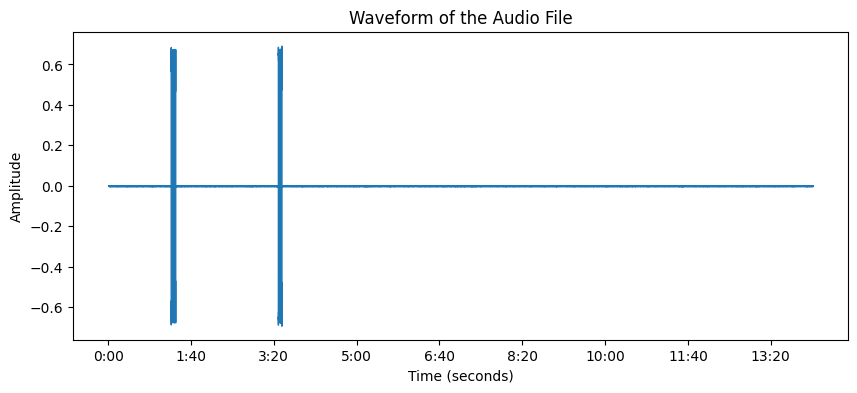

In [3]:
# Path to the audio files
audio_folder = "../data/tartanaviation/raw/kbtp/2020/11/11-02-20_audio"
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]

if not audio_files:
    raise ValueError("No audio files found in the specified directory.")

# Load the first audio file
audio_path = os.path.join(audio_folder, audio_files[0])
audio, sr = librosa.load(audio_path, sr=None)

# Print details
print(f"Loaded file: {audio_files[0]}")
print(f"Sample rate: {sr}")
print(f"Duration: {len(audio) / sr:.2f} seconds")

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of the Audio File")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# Path to the metadata files
metadata_folder = "../data/tartanaviation/raw/kbtp/2020/11/11-02-20_audio"
metadata_files = [f for f in os.listdir(metadata_folder) if f.endswith(".txt")]

if not metadata_files:
    raise ValueError("No metadata files found in the specified directory.")

# Process and print the first metadata file
metadata_path = os.path.join(metadata_folder, metadata_files[0])

with open(metadata_path, 'r') as file:
    metadata_content = file.read()

print(f"Metadata for {metadata_files[0]}:")
print(metadata_content)

Metadata for 1.txt:
Start Time: 
2020-11-02 11:41:33.445474
No metar dataEnd Time: 
2020-11-02 11:55:44.374481
Total Time: 
0:14:10.929010



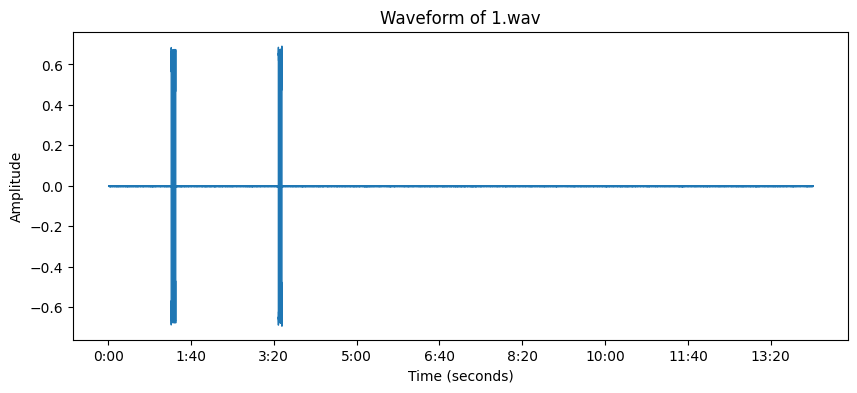

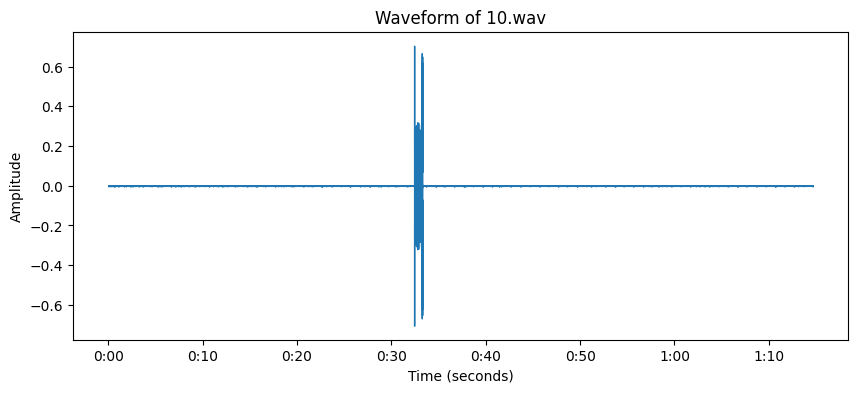

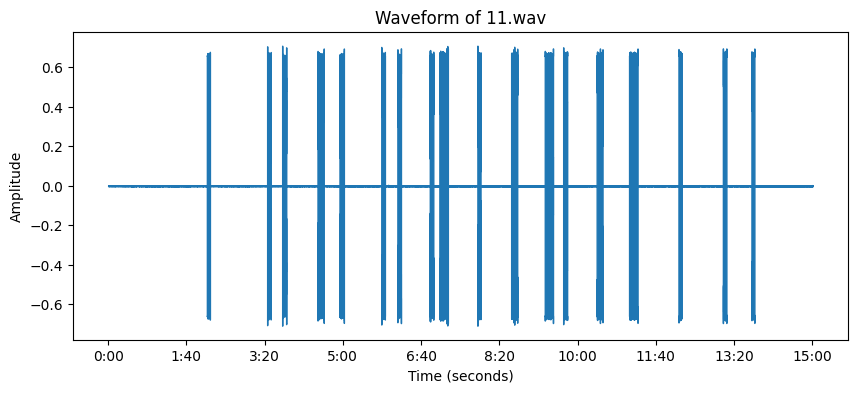

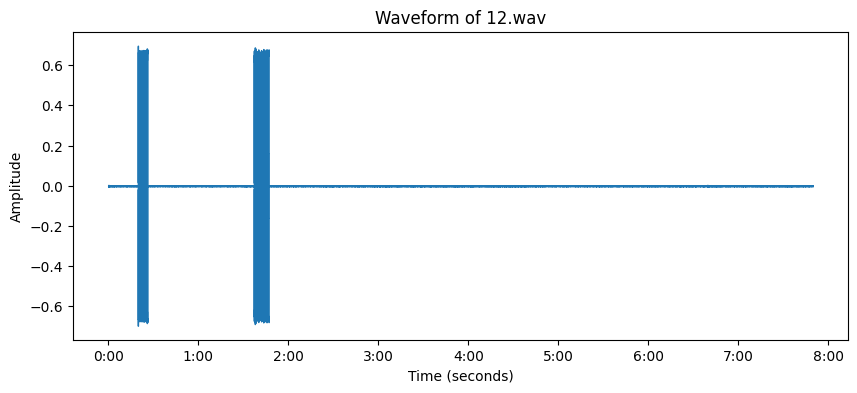

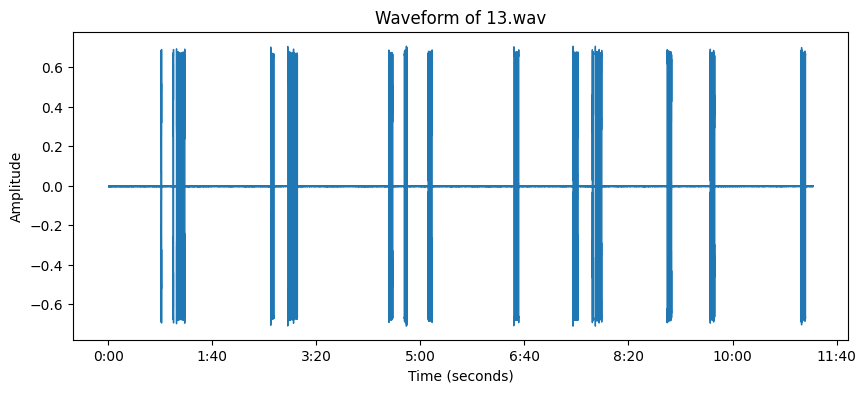

In [5]:
for audio_file in audio_files[:5]:  # Limit to first 5 files for brevity
    # Load each audio file
    audio_path = os.path.join(audio_folder, audio_file)
    audio, sr = librosa.load(audio_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Waveform of {audio_file}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

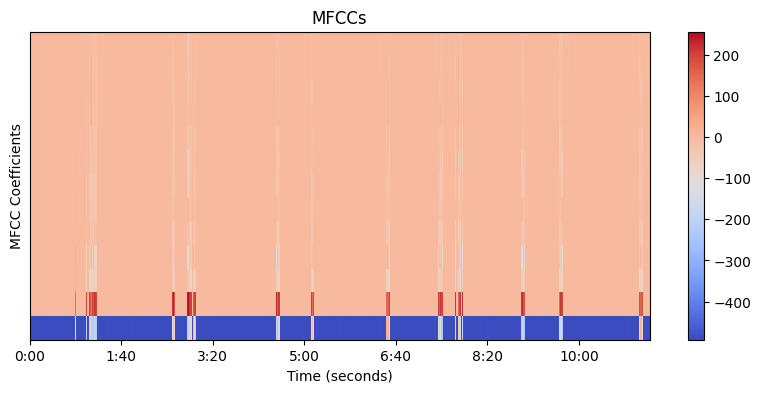

In [6]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

In [7]:
# Convert MFCCs to DataFrame
mfcc_df = pd.DataFrame(mfccs.T, columns=[f"MFCC_{i+1}" for i in range(13)])

# Save to CSV
output_path = "../data/tartanaviation/processed/mfcc_features.csv"
mfcc_df.to_csv(output_path, index=False)
print(f"MFCC features saved to {output_path}")

MFCC features saved to ../data/tartanaviation/processed/mfcc_features.csv


In [8]:
# Define labels (example: binary classification for two classes)
y = np.array([0] * (len(mfcc_df) // 2) + [1] * (len(mfcc_df) - len(mfcc_df) // 2))

# Split data
X = mfcc_df.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels: {np.bincount(y_train)}, Test labels: {np.bincount(y_test)}")

Train shape: (46656, 13), Test shape: (11665, 13)
Train labels: [23328 23328], Test labels: [5832 5833]


In [9]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f"Model trained with accuracy: {clf.score(X_test, y_test):.2f}")

Model trained with accuracy: 0.58


In [10]:
# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.26      0.39      5832
           1       0.55      0.90      0.68      5833

    accuracy                           0.58     11665
   macro avg       0.64      0.58      0.53     11665
weighted avg       0.64      0.58      0.53     11665

Confusion Matrix:
[[1537 4295]
 [ 593 5240]]


In [11]:
from scipy.io.wavfile import write

# Normalize and resample audio
normalized_audio = librosa.util.normalize(audio)
resampled_audio = librosa.resample(normalized_audio, orig_sr=sr, target_sr=16000)

# Save processed audio
output_audio_path = "../data/tartanaviation/processed/processed_audio.wav"
write(output_audio_path, 16000, (resampled_audio * 32767).astype(np.int16))
print(f"Processed audio saved to {output_audio_path}")

Processed audio saved to ../data/tartanaviation/processed/processed_audio.wav


In [12]:
# Load audio file
audio_folder = "../data/tartanaviation/raw/kbtp/2020/11/11-02-20_audio"
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]

# Load the first audio file
audio_path = os.path.join(audio_folder, audio_files[0])
audio, sr = librosa.load(audio_path, sr=None)

# Print audio details
print(f"Audio file: {audio_files[0]}")
print(f"Sample Rate: {sr}")
print(f"Audio Duration: {len(audio) / sr:.2f} seconds")

Audio file: 1.wav
Sample Rate: 44100
Audio Duration: 850.83 seconds


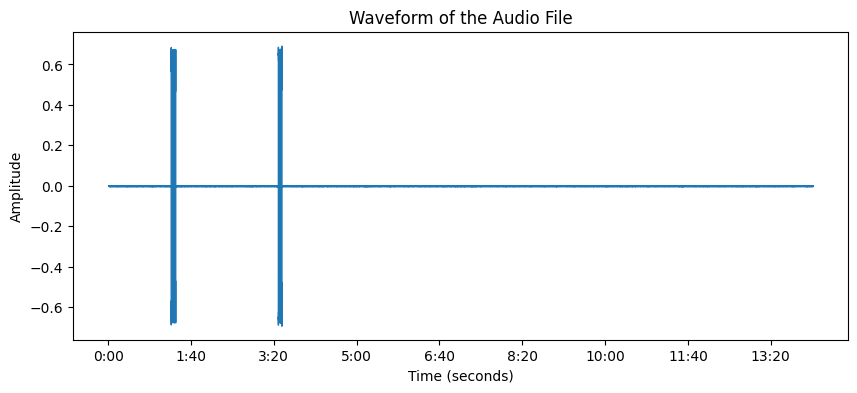

In [13]:
# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of the Audio File")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [14]:
# Normalize and resample audio
normalized_audio = librosa.util.normalize(audio)
resampled_audio = librosa.resample(normalized_audio, orig_sr=sr, target_sr=16000)

# Save processed audio
output_audio_path = "../data/tartanaviation/processed/processed_audio.wav"
write(output_audio_path, 16000, (resampled_audio * 32767).astype(np.int16))
print(f"Processed audio saved to {output_audio_path}")

Processed audio saved to ../data/tartanaviation/processed/processed_audio.wav


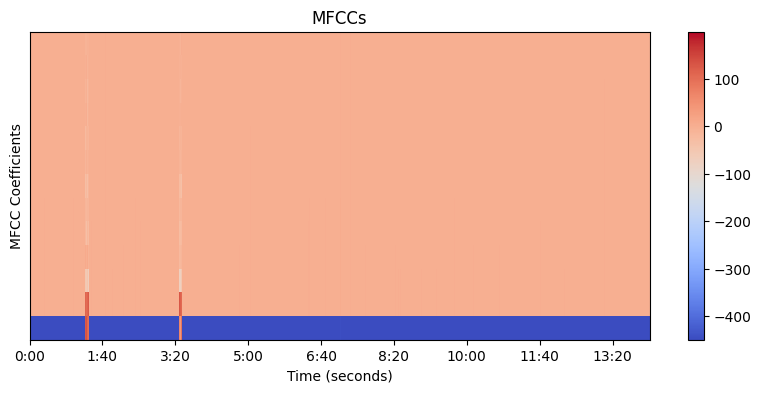

In [15]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=resampled_audio, sr=16000, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=16000)
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

In [16]:
# Convert MFCCs to a DataFrame
mfcc_df = pd.DataFrame(mfccs.T, columns=[f"MFCC_{i+1}" for i in range(13)])

# Save to CSV
output_path = "../data/tartanaviation/processed/mfcc_features.csv"
mfcc_df.to_csv(output_path, index=False)
print(f"MFCC features saved to {output_path}")

MFCC features saved to ../data/tartanaviation/processed/mfcc_features.csv


In [17]:
# Load labels (simulated for this example)
num_samples = len(mfcc_df)
y = np.random.randint(0, 3, num_samples)  # Simulated labels: 3 classes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(mfcc_df.values, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Train class distribution: [7011 7184 7076]
Test class distribution: [1753 1796 1769]


In [18]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
print(f"Train Accuracy: {clf.score(X_train, y_train)}")
print(f"Test Accuracy: {clf.score(X_test, y_test)}")

Train Accuracy: 0.43533449297165155
Test Accuracy: 0.34110567882662657


In [19]:
# Predictions
y_pred = clf.predict(X_test)

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.06      0.10      1753
           1       0.34      0.91      0.50      1796
           2       0.32      0.04      0.07      1769

    accuracy                           0.34      5318
   macro avg       0.34      0.34      0.22      5318
weighted avg       0.34      0.34      0.22      5318

Confusion Matrix:
[[ 100 1566   87]
 [  88 1640   68]
 [  91 1604   74]]


In [20]:
# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

# Build a simple neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=10, batch_size=32)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3381 - loss: 15.4669 - val_accuracy: 0.3383 - val_loss: 1.1043
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3337 - loss: 1.1420 - val_accuracy: 0.3377 - val_loss: 1.0990
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3353 - loss: 1.1188 - val_accuracy: 0.3377 - val_loss: 1.0987
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3330 - loss: 1.1037 - val_accuracy: 0.3377 - val_loss: 1.0986
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3381 - loss: 1.1008 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3419 - loss: 1.1032 - val_accuracy: 0.3325 - val_loss: 1.0986
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3319 - loss: 1.1013 - val_accuracy: 0.3379 - val_loss: 1.0985
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3364 - loss: 1.0990 - val_accuracy: 0

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Neural Network Test Accuracy: {accuracy:.2f}")

# Predictions
y_pred_nn = np.argmax(model.predict(X_test), axis=1)

# Classification report for neural network
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3328 - loss: 1.0988
Neural Network Test Accuracy: 0.34
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1753
           1       0.34      1.00      0.50      1796
           2       0.00      0.00      0.00      1769

    accuracy                           0.34      5318
   macro avg       0.11      0.33      0.17      5318
weighted avg       0.11      0.34      0.17      5318



C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [ ]:
# Speech2Text: Wav2Vec2 Implementation
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Function to transcribe audio using Wav2Vec2
def transcribe_audio(audio_path):
    audio_input, sr = librosa.load(audio_path, sr=16000)  # Ensure 16kHz for Wav2Vec2
    input_values = processor(audio_input, return_tensors="pt", sampling_rate=16000).input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

# Example: Transcribing a file
audio_file_path = "../data/tartanaviation/processed/processed_audio.wav"
transcription = transcribe_audio(audio_file_path)
print(f"Transcription: {transcription}")

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Michael\.cache\huggingface\hub\models--facebook--wav2vec2-large-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at 

In [ ]:
# Speech2Intent: Intent Classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Sample labeled data (replace with actual labeled data)
texts = [
    "Request clearance to take off runway 22",
    "Alert: Aircraft entering restricted airspace",
    "Request weather update",
]
labels = ["clearance_request", "alert", "weather_request"]

# Vectorize text data
vectorizer = CountVectorizer()
X_texts = vectorizer.fit_transform(texts)

# Train a Logistic Regression classifier
intent_classifier = LogisticRegression()
intent_classifier.fit(X_texts, labels)

# Function to classify intent
def classify_intent(transcription):
    X_transcription = vectorizer.transform([transcription])
    intent = intent_classifier.predict(X_transcription)[0]
    return intent

# Example: Classify intent of the transcribed text
intent = classify_intent(transcription)
print(f"Detected Intent: {intent}")

In [ ]:
# Speech2Action: Real-time Decision Support
# Mock trajectory and weather data (replace with actual data sources)
trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

# Function to suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}."
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}."
    else:
        return "No action required."

# Example: Suggest action
action = suggest_action(intent, trajectory_data, weather_data)
print(f"Suggested Action: {action}")